In [74]:
import glob # For getting file names
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
# import torch

from collections import Counter
# from gap_statistic import OptimalK
from scipy import stats, cluster
from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer

from utils.clustering_utils import *
from utils.conformal_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
def generate_n_clustering_list(rarest_class_ct):
    '''
    Generate candidate n_clustering values 
    '''
    n_clustering_list = (np.array([.3, .5, .7, .9]) * rarest_class_ct).astype(np.int32)
    
    return n_clustering_list

def generate_num_clusters_list(num_classes):
    '''
    Generate candidate num_clusters values 
    '''
    # List of possible numbers of clusters (1-10, then grid of 5 points through 10% of num_classes)
    grid1 = np.arange(1, 11, dtype=int)
    grid2 = np.linspace(10, np.ceil(.1 * num_classes)+1, 5, dtype=int)
    num_clusters_list = np.unique(np.concatenate((grid1, grid2)))
    
    return num_clusters_list
    

def compute_metrics_matrix(totalcal_scores_all, totalcal_labels,
                        alpha,
                        val_scores_all, val_labels, save_to=None,
                        n_clustering_list=None, num_clusters_list=None):
    '''
    save_to: file path to save metrics matix to
    '''
    
    num_classes = totalcal_scores_all.shape[1]
    
    if n_clustering_list is None:
        rarest_class_ct = Counter(totalcal_labels).most_common()[-1][1]
        n_clustering_list = generate_n_clustering_list(rarest_class_ct)
        
    if num_clusters_list is None:
        num_clusters_list = generate_num_clusters_list(num_classes)
        
        
    print('n_clustering_list:', n_clustering_list)
    print('num_clusters_list:', num_clusters_list)
        
    results = {} # For storing coverage and set size metrics
    
    for n_clustering in n_clustering_list:
        results[f'n_clustering={n_clustering}'] = {}
            
        for num_clusters in num_clusters_list: 
            results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}'] = {}
            
            qhats, preds, coverage_metrics, set_size_metrics = clustered_conformal(totalcal_scores_all, totalcal_labels,
                                                                alpha,
                                                                n_clustering, num_clusters,
                                                                val_scores_all=val_scores_all, val_labels=val_labels)
    
            results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics'] = coverage_metrics
            results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics'] = set_size_metrics
    
    if save_to is not None:
        with open(save_to,'wb') as f:
            pickle.dump(results, f)
            print(f'Saved metrics matrix to {save_to}')
    
    return results, n_clustering_list, num_clusters_list
    
def compute_N_metrics_matrices(scores_all, labels, n_totalcal,
                                alpha, save_folder,
                                seeds=[0,1,2,3,4],
                                n_clustering_list=None, num_clusters_list=None):
    '''
    Computes N different metrics matrices, each for a different calibration/validation
    split. N=len(seeds)
    
    Inputs:
        -seeds: list of ints used to seed the random data splitting
    '''
    os.makedirs(save_folder, exist_ok=True)

    for seed in seeds:
        totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=seed)
        
        print(f'Computing metrics matrix for seed={seed}...')
        save_to = os.path.join(save_folder, f'seed={seed}_allmetrics.pkl')
        compute_metrics_matrix(totalcal_scores_all, totalcal_labels,
                                            alpha,
                                            val_scores_all, val_labels, save_to=save_to,
                                            n_clustering_list=None, num_clusters_list=None)
    
    
def visualize_heatmaps(results, n_clustering_list, num_clusters_list, n_totalcal):
    '''
    Visualizes metric matrix using metrics from a single random seed. 
    
    Input:
        - results: 
            metrics matrix, as produced by compute_metrics_matrix(), OR
            list of metrics matrices
    '''
    
    cov_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics']['mean_class_cov_gap']
                       for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
    cov_arr = np.array(cov_arr) * 100

    avg_set_size_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics']['mean']
                       for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
    # Can also make plots for set size quantiles

    title_prefix = f'[{score_function}]'

    ax = sns.heatmap(cov_arr, annot=True,
                    cmap=sns.color_palette("viridis_r", as_cmap=True))
    ax.set(title=f'{title_prefix} Average class coverage gap (%)',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()

    ax = sns.heatmap(avg_set_size_arr, annot=True,
                     cmap=sns.color_palette("magma_r", as_cmap=True),
                     vmax=40)
    ax.set(title=f'{title_prefix} Average set size',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()
    
def visualize_heatmaps_with_SE(folder, n_clustering_list, num_clusters_list, n_totalcal):
    '''
    Visualizes metric matrix using metrics from multiple random seeds. Computes mean and
    standard error across random seeds.
    
    Input:
        - folder: path to folder containing saved metric matrices, as produced by 
        compute_metrics_matrix() All files in the folder that match "*.pkl" will be used. 

    '''
    
    file_names = sorted(glob.glob(os.path.join(folder, '*.pkl')))
#     print('Files found:', file_names)
    
    cov_arr_all = []
    avg_set_size_arr_all = []
        
    for pth in file_names:
        with open(pth, 'rb') as f:
            results = pickle.load(f)

        cov_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['coverage_metrics']['mean_class_cov_gap']
                           for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
        cov_arr = np.array(cov_arr) * 100

        avg_set_size_arr = [[results[f'n_clustering={n_clustering}'][f'num_clusters={num_clusters}']['set_size_metrics']['mean']
                       for n_clustering in n_clustering_list] for num_clusters in num_clusters_list]
    
        cov_arr_all.append(cov_arr)
        avg_set_size_arr_all.append(avg_set_size_arr)
    
    cov_arr_all = np.array(cov_arr_all)
    avg_set_size_arr_all = np.array(avg_set_size_arr_all)
    
    title_prefix = f'[{score_function}]'
    
    cov_mean = np.mean(cov_arr_all, axis=0)
    cov_se = np.std(cov_arr_all, axis=0) / np.sqrt(len(file_names) - 1)
    plt_labels = np.array([[f'{cov_mean[i,j]:.2f} ({cov_se[i,j]:.2f})' for j in range(cov_mean.shape[1])] for i in range(cov_mean.shape[0])])
    ax = sns.heatmap(cov_mean, annot=plt_labels, fmt = '',
                    cmap=sns.color_palette("viridis_r", as_cmap=True))
    ax.set(title=f'{title_prefix} Class coverage gap as % (SE in parentheses)',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()

    # Plot average set size
    size_mean = np.mean(avg_set_size_arr_all, axis=0)
    size_se = np.std(avg_set_size_arr_all, axis=0) / np.sqrt(len(file_names) - 1)
    plt_labels = np.array([[f'{size_mean[i,j]:.2f} ({size_se[i,j]:.2f})' for j in range(size_mean.shape[1])] for i in range(size_mean.shape[0])])
    ax = sns.heatmap(size_mean, annot=plt_labels, fmt = '',
                     cmap=sns.color_palette("magma_r", as_cmap=True),
                     vmax=40)
    ax.set(title=f'{title_prefix} Average set size (SE in parentheses)',
           xlabel=f"# of points used for clustering (out of {n_totalcal})", 
           ylabel="# of clusters")
    ax.set_xticklabels(n_clustering_list)
    ax.set_yticklabels(num_clusters_list)
    plt.show()

# Run

In [67]:
alpha = .1
n_totalcal = 10 # Total number of calibration points (= # clustering examples + # conformal calibration examples)


# Enron - BERT
softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_softmax_bert.npy"
labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_labels_bert.npy"

save_folder = f'.cache/enron_n={n_totalcal}'

In [68]:
# Load data
print('Loading softmax scores and labels...')

softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

Loading softmax scores and labels...


In [69]:
for score_function in ['softmax', 'APS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')

    curr_save_folder = os.path.join(save_folder, score_function)
    compute_N_metrics_matrices(scores_all, labels, n_totalcal,
                                    alpha, curr_save_folder,
                                    seeds=[0,1,2,3,4],
                                    n_clustering_list=None, num_clusters_list=None)

====== score_function=softmax ======
Computing conformal score...
Computing metrics matrix for seed=0...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [87, 22]
Cluster sizes: [74, 28, 7]
Cluster sizes: [62, 26, 17, 4]
Cluster sizes: [61, 26, 14, 6, 2]
Cluster sizes: [59, 22, 17, 5, 4, 2]
Cluster sizes: [59, 16, 13, 13, 4, 2, 2]
Cluster sizes: [59, 16, 13, 13, 3, 2, 2, 1]
Cluster sizes: [59, 16, 12, 11, 3, 3, 2, 2, 1]
Cluster sizes: [36, 23, 16, 12, 11, 3, 3, 2, 2, 1]
Cluster sizes: [31, 28, 16, 11, 8, 4, 3, 3, 2, 2, 1]
Cluster sizes: [36, 23, 15, 12, 7, 3, 3, 3, 2, 2, 2, 1]
Cluster sizes: [109]
Cluster sizes: [91, 18]
Cluster sizes: [88, 15, 6]
Cluster sizes: [69, 28, 8, 4]
Cluster sizes: [68, 28, 7, 4, 2]
Cluster sizes: [60, 29, 8, 7, 3, 2]
Cluster sizes: [57, 18, 14, 8, 7, 3, 2]
Cluster sizes: [50, 20, 19, 6, 5, 4, 3, 2]
Cluster sizes: [46, 22, 18, 6, 5, 4, 3, 3, 2]
Cluster sizes: [56, 17, 16, 7, 4, 3, 2, 2, 

/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster sizes: [85, 11, 9, 3, 1]
Cluster sizes: [59, 29, 9, 8, 3, 1]
Cluster sizes: [58, 29, 9, 6, 3, 3, 1]
Cluster sizes: [58, 29, 9, 5, 3, 2, 2, 1]
Cluster sizes: [53, 32, 7, 5, 4, 3, 2, 2, 1]


/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster sizes: [58, 29, 5, 5, 4, 3, 2, 1, 1, 1]
Cluster sizes: [53, 28, 7, 5, 4, 4, 3, 2, 1, 1, 1]


/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster sizes: [53, 29, 6, 4, 4, 4, 3, 2, 1, 1, 1, 1]


/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saved metrics matrix to .cache/enron_n=10/softmax/seed=0_allmetrics.pkl
Computing metrics matrix for seed=1...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [91, 17, 1]
Cluster sizes: [64, 32, 12, 1]
Cluster sizes: [57, 34, 11, 6, 1]
Cluster sizes: [57, 34, 10, 5, 2, 1]
Cluster sizes: [57, 34, 10, 4, 2, 1, 1]
Cluster sizes: [51, 31, 13, 6, 4, 2, 1, 1]
Cluster sizes: [50, 29, 13, 5, 4, 4, 2, 1, 1]
Cluster sizes: [38, 22, 22, 12, 4, 4, 3, 2, 1, 1]
Cluster sizes: [37, 22, 20, 12, 4, 4, 3, 3, 2, 1, 1]
Cluster sizes: [37, 19, 14, 11, 10, 5, 4, 3, 2, 2, 1, 1]
Cluster sizes: [109]
Cluster sizes: [93, 16]
Cluster sizes: [74, 27, 8]
Cluster sizes: [69, 31, 7, 2]
Cluster sizes: [64, 29, 10, 4, 2]
Cluster sizes: [64, 29, 11, 3, 1, 1]
Cluster sizes: [64, 26, 10, 5, 2, 1, 1]
Cluster sizes: [48, 22, 21, 9, 5, 2, 1, 1]
Cluster sizes: [48, 21, 21, 9, 4, 3, 1, 1, 1]
Cluster sizes: [44, 22, 21, 7, 6, 3, 3, 1, 1, 1]


/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster sizes: [48, 22, 21, 5, 4, 3, 2, 1, 1, 1, 1]


/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster sizes: [48, 22, 21, 6, 3, 2, 2, 1, 1, 1, 1, 1]


/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saved metrics matrix to .cache/enron_n=10/softmax/seed=1_allmetrics.pkl
Computing metrics matrix for seed=2...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [97, 12]
Cluster sizes: [91, 17, 1]
Cluster sizes: [84, 19, 5, 1]
Cluster sizes: [79, 18, 7, 4, 1]
Cluster sizes: [63, 21, 14, 7, 3, 1]
Cluster sizes: [63, 21, 13, 6, 4, 1, 1]
Cluster sizes: [62, 20, 9, 6, 6, 4, 1, 1]
Cluster sizes: [63, 21, 7, 6, 5, 3, 2, 1, 1]
Cluster sizes: [33, 32, 19, 7, 6, 5, 3, 2, 1, 1]
Cluster sizes: [33, 31, 13, 7, 7, 6, 5, 3, 2, 1, 1]
Cluster sizes: [33, 31, 16, 6, 6, 5, 5, 2, 2, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [95, 14]
Cluster sizes: [82, 25, 2]
Cluster sizes: [74, 23, 10, 2]
Cluster sizes: [73, 24, 9, 2, 1]
Cluster sizes: [60, 22, 17, 7, 2, 1]
Cluster sizes: [59, 22, 16, 7, 3, 1, 1]
Cluster sizes: [58, 22, 15, 7, 3, 2, 1, 1]
Cluster sizes: [59, 22, 9, 7, 6, 2, 2, 1, 1]
Cluster sizes: [37, 29, 15, 9, 7, 5, 3, 2, 1, 1

Cluster sizes: [50, 24, 10, 9, 6, 4, 2, 1, 1, 1, 1]
Cluster sizes: [50, 26, 10, 7, 4, 4, 2, 2, 1, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [93, 16]
Cluster sizes: [93, 14, 2]
Cluster sizes: [74, 21, 12, 2]
Cluster sizes: [72, 21, 10, 5, 1]
Cluster sizes: [72, 21, 6, 5, 4, 1]
Cluster sizes: [48, 29, 16, 6, 5, 4, 1]
Cluster sizes: [48, 29, 16, 6, 4, 4, 1, 1]
Cluster sizes: [48, 29, 16, 4, 4, 4, 2, 1, 1]
Cluster sizes: [42, 27, 12, 12, 5, 4, 4, 1, 1, 1]
Cluster sizes: [33, 27, 19, 14, 4, 3, 3, 3, 1, 1, 1]
Cluster sizes: [41, 27, 13, 12, 4, 3, 3, 2, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=10/softmax/seed=2_allmetrics.pkl
Computing metrics matrix for seed=3...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [97, 12]
Cluster sizes: [92, 12, 5]
Cluster sizes: [71, 25, 8, 5]
Cluster sizes: [67, 24, 8, 5, 5]
Cluster sizes: [67, 24, 6, 5, 5, 2]
Cluster sizes: [67, 24, 5, 5, 4, 3, 1]
Cluster sizes: [35, 32, 2

Cluster sizes: [62, 20, 9, 6, 4, 4, 2, 1, 1]
Cluster sizes: [36, 31, 15, 9, 6, 4, 4, 2, 1, 1]
Cluster sizes: [36, 31, 15, 9, 6, 4, 3, 2, 1, 1, 1]
Cluster sizes: [36, 31, 15, 9, 4, 4, 3, 2, 2, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [97, 12]
Cluster sizes: [92, 14, 3]
Cluster sizes: [89, 13, 4, 3]
Cluster sizes: [66, 26, 10, 4, 3]
Cluster sizes: [66, 26, 10, 4, 2, 1]
Cluster sizes: [66, 26, 6, 4, 4, 2, 1]
Cluster sizes: [65, 20, 7, 6, 4, 4, 2, 1]
Cluster sizes: [64, 21, 7, 6, 4, 4, 1, 1, 1]
Cluster sizes: [65, 20, 7, 5, 4, 4, 1, 1, 1, 1]
Cluster sizes: [64, 21, 7, 5, 4, 3, 1, 1, 1, 1, 1]
Cluster sizes: [64, 13, 8, 7, 4, 3, 3, 3, 1, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [101, 8]
Cluster sizes: [88, 18, 3]
Cluster sizes: [80, 21, 5, 3]
Cluster sizes: [80, 21, 5, 2, 1]
Cluster sizes: [63, 24, 14, 5, 2, 1]
Cluster sizes: [63, 25, 13, 3, 2, 2, 1]
Cluster sizes: [63, 25, 8, 5, 3, 2, 2, 1]
Cluster sizes: [47, 31, 11, 6, 6, 3, 2, 2, 1]
Cluster sizes: [47, 31, 11, 6, 6, 3, 2, 1, 1, 1

Cluster sizes: [89, 17, 3]
Cluster sizes: [81, 21, 4, 3]
Cluster sizes: [81, 20, 3, 3, 2]
Cluster sizes: [81, 20, 3, 2, 2, 1]
Cluster sizes: [67, 22, 12, 3, 2, 2, 1]
Cluster sizes: [67, 22, 12, 3, 2, 1, 1, 1]
Cluster sizes: [48, 33, 15, 5, 3, 2, 1, 1, 1]
Cluster sizes: [56, 27, 14, 4, 2, 2, 1, 1, 1, 1]
Cluster sizes: [48, 33, 10, 6, 4, 2, 2, 1, 1, 1, 1]
Cluster sizes: [48, 33, 10, 6, 4, 2, 1, 1, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=10/softmax/seed=3_allmetrics.pkl
Computing metrics matrix for seed=4...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [92, 17]
Cluster sizes: [90, 18, 1]
Cluster sizes: [69, 25, 14, 1]
Cluster sizes: [63, 27, 10, 8, 1]
Cluster sizes: [65, 25, 10, 4, 4, 1]
Cluster sizes: [48, 25, 17, 10, 4, 4, 1]
Cluster sizes: [39, 30, 21, 6, 6, 4, 2, 1]
Cluster sizes: [39, 28, 14, 9, 8, 4, 4, 2, 1]
Cluster sizes: [36, 23, 16, 15, 8, 4, 2, 2, 2, 1]


Cluster sizes: [39, 26, 15, 10, 4, 4, 4, 2, 2, 2, 1]
Cluster sizes: [33, 19, 17, 14, 7, 4, 4, 4, 2, 2, 2, 1]
Cluster sizes: [109]
Cluster sizes: [91, 18]
Cluster sizes: [84, 18, 7]
Cluster sizes: [81, 20, 7, 1]
Cluster sizes: [77, 18, 8, 5, 1]
Cluster sizes: [60, 27, 12, 5, 4, 1]
Cluster sizes: [60, 24, 9, 6, 5, 4, 1]
Cluster sizes: [60, 27, 6, 6, 4, 3, 2, 1]
Cluster sizes: [54, 23, 10, 6, 6, 4, 3, 2, 1]
Cluster sizes: [31, 29, 17, 10, 6, 6, 4, 3, 2, 1]
Cluster sizes: [31, 29, 17, 7, 6, 5, 4, 4, 3, 2, 1]
Cluster sizes: [32, 28, 17, 7, 6, 6, 3, 3, 2, 2, 2, 1]
Cluster sizes: [109]
Cluster sizes: [91, 18]
Cluster sizes: [91, 17, 1]
Cluster sizes: [91, 14, 3, 1]
Cluster sizes: [68, 23, 14, 3, 1]
Cluster sizes: [68, 23, 9, 5, 3, 1]
Cluster sizes: [69, 22, 5, 5, 4, 3, 1]
Cluster sizes: [69, 22, 5, 5, 4, 2, 1, 1]
Cluster sizes: [40, 34, 17, 5, 5, 4, 2, 1, 1]
Cluster sizes: [40, 34, 17, 5, 4, 4, 2, 1, 1, 1]
Cluster sizes: [35, 34, 16, 6, 5, 4, 4, 2, 1, 1, 1]
Cluster sizes: [36, 32, 11, 10, 4, 

Cluster sizes: [43, 32, 15, 7, 4, 3, 2, 2, 1]
Cluster sizes: [43, 32, 15, 7, 3, 3, 3, 1, 1, 1]
Cluster sizes: [32, 31, 14, 13, 7, 3, 3, 2, 2, 1, 1]
Cluster sizes: [39, 29, 13, 9, 7, 3, 2, 2, 2, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=10/softmax/seed=4_allmetrics.pkl
====== score_function=APS ======
Computing conformal score...
Computing metrics matrix for seed=0...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [63, 46]
Cluster sizes: [44, 37, 28]
Cluster sizes: [32, 27, 26, 24]
Cluster sizes: [29, 25, 23, 18, 14]
Cluster sizes: [26, 25, 18, 17, 12, 11]
Cluster sizes: [22, 19, 17, 16, 14, 12, 9]
Cluster sizes: [19, 19, 18, 16, 12, 12, 7, 6]
Cluster sizes: [19, 18, 16, 14, 12, 11, 7, 7, 5]
Cluster sizes: [20, 17, 12, 11, 10, 9, 9, 9, 7, 5]
Cluster sizes: [19, 12, 12, 11, 11, 9, 9, 8, 7, 6, 5]
Cluster sizes: [17, 13, 13, 13, 9, 9, 7, 7, 6, 5, 5, 5]
Cluster sizes: [109]
Cluster sizes: [66, 43]
Cluster sizes

Cluster sizes: [26, 25, 21, 14, 14, 9]
Cluster sizes: [26, 18, 18, 14, 13, 11, 9]
Cluster sizes: [21, 18, 18, 15, 11, 10, 8, 8]
Cluster sizes: [18, 14, 13, 12, 12, 12, 11, 9, 8]
Cluster sizes: [15, 14, 13, 12, 11, 10, 9, 9, 8, 8]
Cluster sizes: [17, 13, 11, 11, 9, 9, 9, 8, 8, 8, 6]
Cluster sizes: [14, 11, 10, 10, 10, 9, 8, 8, 8, 8, 7, 6]
Cluster sizes: [109]
Cluster sizes: [67, 42]
Cluster sizes: [52, 32, 25]
Cluster sizes: [41, 26, 25, 17]
Cluster sizes: [31, 25, 19, 18, 16]
Cluster sizes: [29, 19, 18, 17, 13, 13]
Cluster sizes: [22, 22, 19, 15, 14, 10, 7]
Cluster sizes: [28, 19, 17, 13, 10, 9, 9, 4]
Cluster sizes: [16, 16, 15, 14, 12, 11, 10, 9, 6]
Cluster sizes: [21, 17, 13, 12, 11, 10, 8, 7, 6, 4]
Cluster sizes: [20, 16, 12, 12, 11, 10, 9, 7, 6, 4, 2]
Cluster sizes: [19, 18, 11, 11, 10, 9, 8, 7, 6, 4, 4, 2]
Cluster sizes: [109]
Cluster sizes: [60, 49]
Cluster sizes: [44, 41, 24]
Cluster sizes: [39, 33, 28, 9]
Cluster sizes: [31, 25, 23, 21, 9]
Cluster sizes: [26, 22, 20, 19, 13, 9]

/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster sizes: [33, 23, 19, 18, 16]
Cluster sizes: [23, 20, 18, 16, 16, 16]
Cluster sizes: [20, 18, 16, 15, 14, 13, 13]
Cluster sizes: [24, 17, 14, 14, 14, 13, 8, 5]
Cluster sizes: [18, 16, 15, 14, 14, 12, 11, 5, 4]
Cluster sizes: [15, 15, 13, 13, 12, 11, 11, 10, 5, 4]
Cluster sizes: [17, 15, 13, 13, 11, 10, 9, 8, 5, 4, 4]


/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tding/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cluster sizes: [14, 12, 11, 10, 10, 10, 9, 9, 9, 7, 4, 4]
Saved metrics matrix to .cache/enron_n=10/APS/seed=1_allmetrics.pkl
Computing metrics matrix for seed=2...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [58, 51]
Cluster sizes: [46, 35, 28]
Cluster sizes: [34, 32, 28, 15]
Cluster sizes: [32, 31, 18, 15, 13]
Cluster sizes: [28, 21, 17, 17, 14, 12]
Cluster sizes: [20, 17, 17, 17, 16, 12, 10]
Cluster sizes: [16, 16, 15, 14, 13, 13, 12, 10]
Cluster sizes: [19, 16, 12, 12, 11, 11, 10, 10, 8]
Cluster sizes: [18, 12, 11, 11, 11, 10, 10, 10, 9, 7]
Cluster sizes: [18, 11, 11, 11, 10, 10, 9, 8, 8, 7, 6]
Cluster sizes: [13, 13, 11, 10, 10, 10, 10, 9, 7, 6, 5, 5]
Cluster sizes: [109]
Cluster sizes: [58, 51]
Cluster sizes: [44, 33, 32]
Cluster sizes: [31, 31, 28, 19]
Cluster sizes: [32, 30, 18, 16, 13]
Cluster sizes: [25, 23, 17, 16, 16, 12]
Cluster sizes: [18, 18, 16, 16, 15, 13, 13]
Cluster sizes: [21, 18, 16, 15, 

Cluster sizes: [18, 11, 11, 10, 10, 9, 9, 8, 6, 6, 6, 5]
Saved metrics matrix to .cache/enron_n=10/APS/seed=3_allmetrics.pkl
Computing metrics matrix for seed=4...
n_clustering_list: [3 5 7 9]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [70, 39]
Cluster sizes: [47, 32, 30]
Cluster sizes: [38, 30, 23, 18]
Cluster sizes: [28, 24, 22, 20, 15]
Cluster sizes: [22, 22, 18, 17, 16, 14]
Cluster sizes: [21, 17, 17, 16, 15, 14, 9]
Cluster sizes: [22, 16, 14, 14, 14, 12, 9, 8]
Cluster sizes: [16, 14, 14, 13, 13, 11, 11, 9, 8]
Cluster sizes: [15, 14, 13, 13, 11, 10, 9, 9, 8, 7]
Cluster sizes: [15, 13, 11, 11, 10, 9, 9, 8, 8, 8, 7]
Cluster sizes: [13, 12, 11, 11, 11, 10, 8, 8, 7, 7, 6, 5]
Cluster sizes: [109]
Cluster sizes: [62, 47]
Cluster sizes: [53, 29, 27]
Cluster sizes: [36, 25, 25, 23]
Cluster sizes: [30, 23, 22, 17, 17]
Cluster sizes: [25, 23, 17, 16, 15, 13]
Cluster sizes: [22, 18, 18, 15, 14, 12, 10]
Cluster sizes: [22, 17, 16, 15, 14, 11, 9

folder: .cache/enron_n=10/softmax


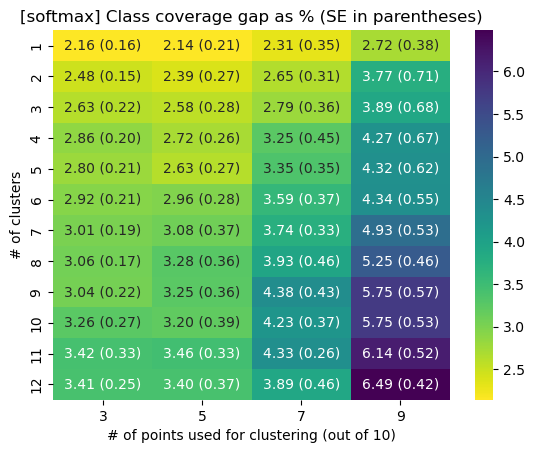

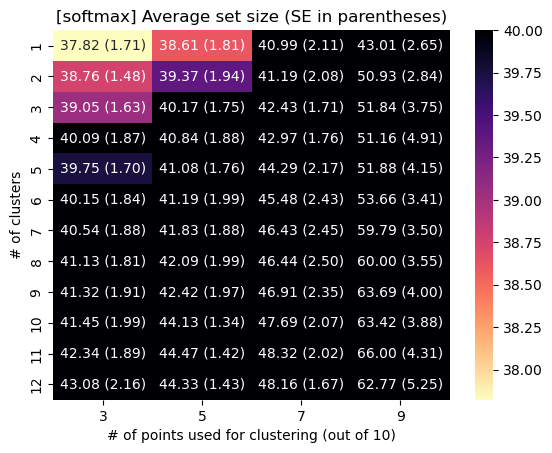

folder: .cache/enron_n=10/APS


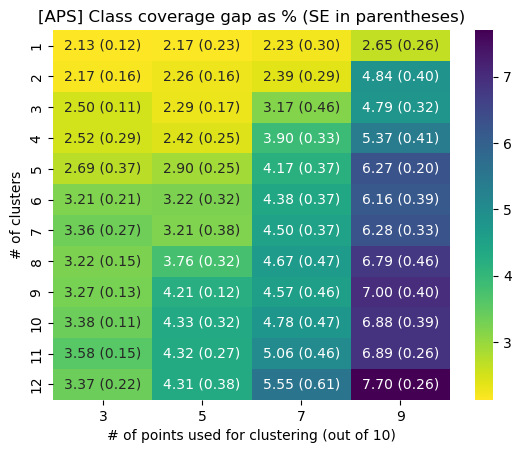

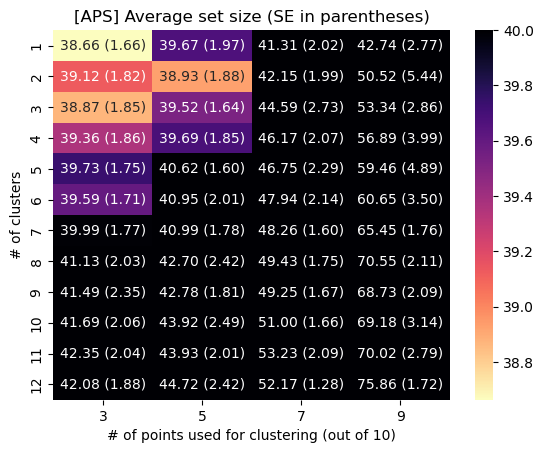

In [93]:
n_totalcal = 10
save_folder = f'.cache/enron_n={n_totalcal}'

# Load precomputed metrics and make heatmaps
n_clustering_list = generate_n_clustering_list(n_totalcal)
num_clustering_list = generate_num_clusters_list(num_classes)
for score_function in ['softmax', 'APS']:
    
    folder = os.path.join(save_folder, score_function)
    print('folder:', folder)
    visualize_heatmaps_with_SE(folder, n_clustering_list, num_clusters_list, n_totalcal)
    

In [70]:
# Also run for n=20
n_totalcal = 20
save_folder = f'.cache/enron_n={n_totalcal}'

for score_function in ['softmax', 'APS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')

    curr_save_folder = os.path.join(save_folder, score_function)
    compute_N_metrics_matrices(scores_all, labels, n_totalcal,
                                    alpha, curr_save_folder,
                                    seeds=[0,1,2,3,4],
                                    n_clustering_list=None, num_clusters_list=None)

====== score_function=softmax ======
Computing conformal score...
Computing metrics matrix for seed=0...
n_clustering_list: [ 6 10 14 18]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [98, 11]
Cluster sizes: [98, 9, 2]
Cluster sizes: [61, 37, 9, 2]
Cluster sizes: [78, 20, 7, 2, 2]
Cluster sizes: [54, 31, 13, 7, 2, 2]
Cluster sizes: [54, 31, 13, 7, 2, 1, 1]
Cluster sizes: [47, 22, 18, 11, 7, 2, 1, 1]
Cluster sizes: [54, 25, 11, 8, 7, 1, 1, 1, 1]
Cluster sizes: [54, 24, 10, 10, 4, 3, 1, 1, 1, 1]
Cluster sizes: [54, 24, 10, 8, 3, 3, 2, 2, 1, 1, 1]
Cluster sizes: [54, 22, 10, 7, 5, 3, 3, 1, 1, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [95, 14]
Cluster sizes: [94, 11, 4]
Cluster sizes: [65, 29, 11, 4]
Cluster sizes: [65, 29, 11, 3, 1]
Cluster sizes: [65, 29, 7, 4, 3, 1]
Cluster sizes: [68, 26, 6, 4, 3, 1, 1]
Cluster sizes: [65, 29, 6, 3, 2, 2, 1, 1]
Cluster sizes: [59, 22, 13, 6, 3, 2, 2, 1, 1]
Cluster sizes: [59, 22, 13, 6, 2, 2, 2, 1, 1, 1

Cluster sizes: [48, 22, 19, 7, 3, 3, 2, 2, 1, 1, 1]
Cluster sizes: [47, 23, 19, 6, 4, 3, 2, 1, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=20/softmax/seed=0_allmetrics.pkl
Computing metrics matrix for seed=1...
n_clustering_list: [ 6 10 14 18]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [97, 12]
Cluster sizes: [90, 17, 2]
Cluster sizes: [75, 22, 11, 1]
Cluster sizes: [75, 22, 10, 1, 1]
Cluster sizes: [62, 29, 10, 6, 1, 1]
Cluster sizes: [61, 26, 11, 6, 3, 1, 1]
Cluster sizes: [60, 27, 10, 5, 3, 2, 1, 1]
Cluster sizes: [61, 20, 9, 8, 6, 2, 1, 1, 1]
Cluster sizes: [48, 24, 12, 8, 5, 4, 3, 3, 1, 1]
Cluster sizes: [41, 31, 12, 7, 6, 3, 3, 3, 1, 1, 1]
Cluster sizes: [38, 31, 12, 8, 6, 4, 3, 2, 2, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [100, 9]
Cluster sizes: [96, 12, 1]
Cluster sizes: [84, 16, 8, 1]
Cluster sizes: [74, 22, 7, 5, 1]
Cluster sizes: [63, 28, 9, 6, 2, 1]
Cluster sizes: [53, 31, 12, 5, 5, 2, 1]
Cluster sizes: [53, 31,

Cluster sizes: [47, 34, 16, 5, 2, 2, 1, 1, 1]
Cluster sizes: [38, 32, 17, 12, 3, 2, 2, 1, 1, 1]
Cluster sizes: [47, 29, 12, 11, 3, 2, 1, 1, 1, 1, 1]
Cluster sizes: [29, 27, 21, 11, 11, 3, 2, 1, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=20/softmax/seed=1_allmetrics.pkl
Computing metrics matrix for seed=2...
n_clustering_list: [ 6 10 14 18]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [94, 15]
Cluster sizes: [84, 19, 6]
Cluster sizes: [84, 19, 4, 2]
Cluster sizes: [82, 14, 8, 3, 2]
Cluster sizes: [42, 41, 13, 8, 3, 2]
Cluster sizes: [42, 41, 12, 6, 3, 3, 2]
Cluster sizes: [45, 39, 10, 4, 3, 3, 3, 2]
Cluster sizes: [45, 38, 6, 6, 5, 3, 3, 2, 1]
Cluster sizes: [33, 30, 21, 6, 5, 5, 3, 3, 2, 1]
Cluster sizes: [36, 30, 18, 9, 4, 3, 2, 2, 2, 2, 1]
Cluster sizes: [35, 30, 19, 8, 4, 3, 2, 2, 2, 2, 1, 1]
Cluster sizes: [109]
Cluster sizes: [86, 23]
Cluster sizes: [86, 15, 8]
Cluster sizes: [86, 17, 4, 2]
Cluster sizes: [86, 11, 8, 2, 2]
Cl

Cluster sizes: [66, 25, 8, 5, 3, 1, 1]
Cluster sizes: [38, 33, 20, 7, 6, 3, 1, 1]
Cluster sizes: [38, 33, 19, 8, 5, 3, 1, 1, 1]
Cluster sizes: [38, 33, 19, 8, 5, 2, 1, 1, 1, 1]
Cluster sizes: [38, 33, 18, 6, 6, 2, 2, 1, 1, 1, 1]
Cluster sizes: [38, 33, 19, 5, 5, 2, 2, 1, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=20/softmax/seed=2_allmetrics.pkl
Computing metrics matrix for seed=3...
n_clustering_list: [ 6 10 14 18]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [99, 10]
Cluster sizes: [69, 33, 7]
Cluster sizes: [68, 31, 7, 3]
Cluster sizes: [68, 31, 5, 3, 2]
Cluster sizes: [57, 25, 17, 5, 3, 2]
Cluster sizes: [63, 21, 8, 7, 5, 3, 2]
Cluster sizes: [55, 19, 18, 7, 5, 2, 2, 1]
Cluster sizes: [55, 16, 15, 8, 5, 5, 2, 2, 1]
Cluster sizes: [55, 15, 13, 10, 5, 3, 3, 2, 2, 1]
Cluster sizes: [52, 17, 14, 7, 4, 4, 3, 3, 2, 2, 1]
Cluster sizes: [45, 24, 15, 8, 4, 3, 3, 2, 2, 1, 1, 1]
Cluster sizes: [109]
Cluster sizes: [103, 6]
Cluster sizes

Cluster sizes: [109]
Cluster sizes: [100, 9]
Cluster sizes: [90, 14, 5]
Cluster sizes: [90, 14, 3, 2]
Cluster sizes: [60, 31, 13, 3, 2]
Cluster sizes: [60, 30, 10, 4, 3, 2]
Cluster sizes: [56, 34, 10, 3, 3, 2, 1]
Cluster sizes: [60, 30, 7, 4, 3, 2, 2, 1]
Cluster sizes: [42, 29, 20, 8, 3, 2, 2, 2, 1]
Cluster sizes: [42, 26, 22, 7, 4, 3, 2, 1, 1, 1]
Cluster sizes: [42, 23, 15, 11, 8, 3, 2, 2, 1, 1, 1]
Cluster sizes: [42, 23, 15, 11, 6, 3, 3, 2, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=20/softmax/seed=3_allmetrics.pkl
Computing metrics matrix for seed=4...
n_clustering_list: [ 6 10 14 18]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [92, 17]
Cluster sizes: [74, 23, 12]
Cluster sizes: [74, 23, 8, 4]
Cluster sizes: [70, 21, 11, 4, 3]
Cluster sizes: [55, 25, 17, 5, 4, 3]
Cluster sizes: [52, 23, 16, 6, 5, 4, 3]
Cluster sizes: [53, 22, 16, 6, 5, 3, 3, 1]
Cluster sizes: [47, 27, 17, 6, 5, 3, 2, 1, 1]
Cluster sizes: [55, 24, 7, 6, 5, 5, 3

Cluster sizes: [40, 33, 13, 5, 4, 3, 3, 2, 2, 2, 1, 1]
Cluster sizes: [109]
Cluster sizes: [101, 8]
Cluster sizes: [90, 14, 5]
Cluster sizes: [90, 13, 5, 1]
Cluster sizes: [65, 26, 12, 5, 1]
Cluster sizes: [65, 26, 10, 4, 3, 1]
Cluster sizes: [65, 26, 10, 3, 3, 1, 1]
Cluster sizes: [42, 38, 13, 8, 3, 3, 1, 1]
Cluster sizes: [42, 30, 12, 9, 8, 3, 3, 1, 1]
Cluster sizes: [42, 36, 11, 8, 4, 3, 2, 1, 1, 1]
Cluster sizes: [46, 33, 8, 7, 7, 2, 2, 1, 1, 1, 1]
Cluster sizes: [42, 35, 11, 10, 3, 2, 1, 1, 1, 1, 1, 1]
Saved metrics matrix to .cache/enron_n=20/softmax/seed=4_allmetrics.pkl
====== score_function=APS ======
Computing conformal score...
Computing metrics matrix for seed=0...
n_clustering_list: [ 6 10 14 18]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [55, 54]
Cluster sizes: [42, 34, 33]
Cluster sizes: [32, 31, 30, 16]
Cluster sizes: [31, 26, 23, 16, 13]
Cluster sizes: [25, 21, 21, 16, 16, 10]
Cluster sizes: [26, 24, 22, 12, 11, 10, 4]


Cluster sizes: [18, 14, 13, 12, 11, 10, 10, 5, 5, 5, 4, 2]
Saved metrics matrix to .cache/enron_n=20/APS/seed=0_allmetrics.pkl
Computing metrics matrix for seed=1...
n_clustering_list: [ 6 10 14 18]
num_clusters_list: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [109]
Cluster sizes: [58, 51]
Cluster sizes: [46, 33, 30]
Cluster sizes: [35, 32, 23, 19]
Cluster sizes: [36, 25, 19, 18, 11]
Cluster sizes: [28, 21, 21, 16, 14, 9]
Cluster sizes: [21, 20, 19, 17, 16, 9, 7]
Cluster sizes: [20, 19, 16, 16, 15, 10, 8, 5]
Cluster sizes: [19, 19, 16, 16, 15, 9, 8, 5, 2]
Cluster sizes: [19, 16, 15, 15, 11, 9, 9, 8, 5, 2]
Cluster sizes: [17, 16, 15, 11, 9, 9, 9, 8, 8, 5, 2]
Cluster sizes: [16, 15, 11, 10, 9, 9, 8, 8, 7, 7, 7, 2]
Cluster sizes: [109]
Cluster sizes: [59, 50]
Cluster sizes: [47, 35, 27]
Cluster sizes: [38, 29, 22, 20]
Cluster sizes: [33, 32, 20, 13, 11]
Cluster sizes: [25, 22, 19, 17, 13, 13]
Cluster sizes: [22, 21, 19, 17, 13, 11, 6]
Cluster sizes: [25, 20, 17, 16, 13, 7, 6, 5]

Cluster sizes: [35, 34, 26, 14]
Cluster sizes: [35, 28, 27, 11, 8]
Cluster sizes: [32, 25, 21, 14, 9, 8]
Cluster sizes: [24, 21, 18, 18, 11, 9, 8]
Cluster sizes: [22, 20, 17, 13, 11, 9, 9, 8]
Cluster sizes: [24, 18, 14, 13, 13, 9, 8, 8, 2]
Cluster sizes: [23, 16, 13, 12, 9, 9, 8, 7, 7, 5]
Cluster sizes: [20, 18, 15, 14, 9, 9, 8, 7, 5, 3, 1]
Cluster sizes: [16, 16, 13, 11, 11, 10, 8, 6, 6, 5, 4, 3]
Cluster sizes: [109]
Cluster sizes: [68, 41]
Cluster sizes: [48, 34, 27]
Cluster sizes: [36, 33, 24, 16]
Cluster sizes: [33, 27, 24, 16, 9]
Cluster sizes: [25, 22, 19, 19, 15, 9]
Cluster sizes: [25, 22, 19, 19, 9, 8, 7]
Cluster sizes: [25, 20, 19, 12, 9, 9, 8, 7]
Cluster sizes: [19, 18, 17, 12, 11, 9, 8, 8, 7]
Cluster sizes: [20, 17, 14, 12, 10, 9, 8, 8, 6, 5]
Cluster sizes: [17, 15, 11, 11, 11, 8, 8, 8, 7, 7, 6]
Cluster sizes: [17, 15, 12, 11, 9, 8, 8, 8, 7, 6, 5, 3]
Cluster sizes: [109]
Cluster sizes: [71, 38]
Cluster sizes: [55, 30, 24]
Cluster sizes: [32, 30, 27, 20]
Cluster sizes: [27, 2

folder: .cache/enron_n=20/softmax


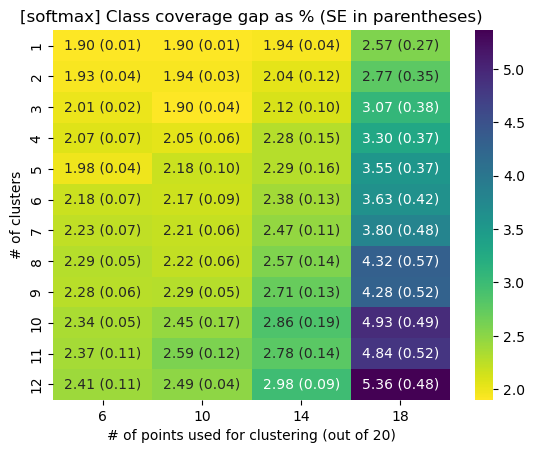

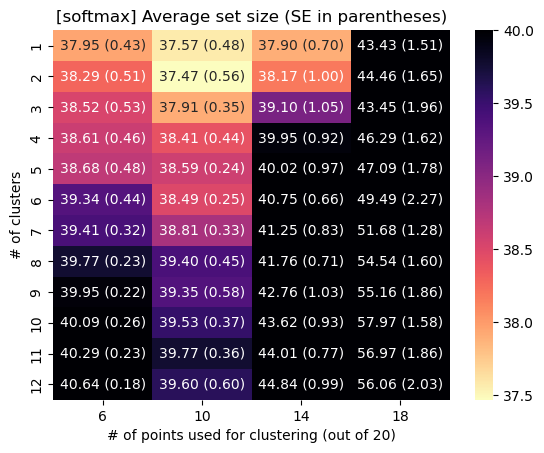

folder: .cache/enron_n=20/APS


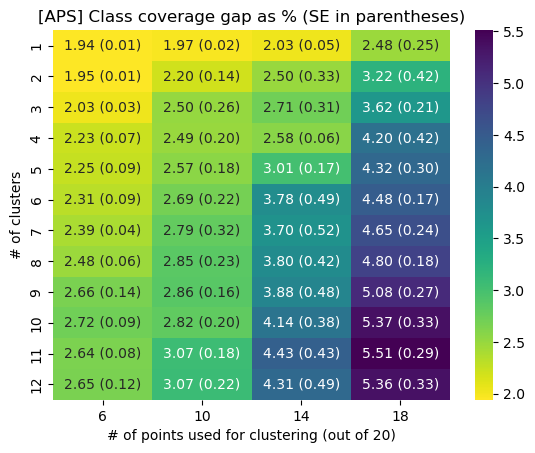

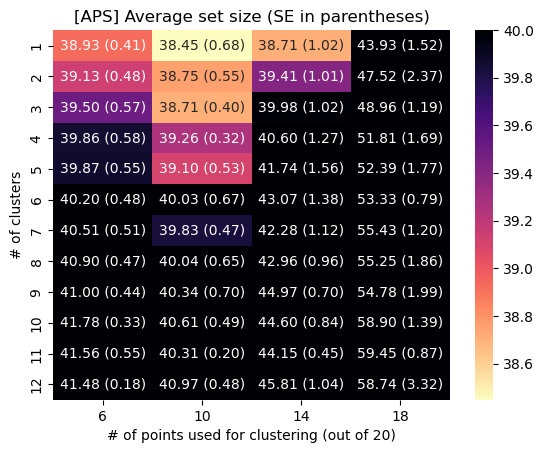

In [94]:
n_totalcal = 20
save_folder = f'.cache/enron_n={n_totalcal}'

# Load precomputed metrics and make heatmaps
n_clustering_list = generate_n_clustering_list(n_totalcal)
num_clustering_list = generate_num_clusters_list(num_classes)
for score_function in ['softmax', 'APS']:
    
    folder = os.path.join(save_folder, score_function)
    print('folder:', folder)
    visualize_heatmaps_with_SE(folder, n_clustering_list, num_clusters_list, n_totalcal)
    

In [ ]:
# TODO: implement cluster-conditional coverage computation (will have to rerun everything)